In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from model import get_resnet
from dataset import get_dataset
import tensorflow_probability as tfp
from tqdm.notebook import tqdm
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Layer, Conv2D
from sparse_conv2d import SparseConv2D
from utils import expand_layer, propagate_constants, copy_layer

# mixed_precision.set_global_policy("mixed_float16")
from tensorflow.keras.utils import register_keras_serializable

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
SIZE = 224
base_model, model = get_resnet()
test_ds, val_ds = get_dataset(False, SIZE, 1, 16, True)
train_ds = get_dataset(True, SIZE, 1, 16, False)

In [4]:
base_model.count_params()

23587712

In [5]:
def test_propagate(layer):
    in_shape = (1,) + layer.input_shape[1:]
    csts = tf.random.uniform(in_shape, dtype=tf.float16)
    mask = tf.cast(tf.random.uniform(in_shape, minval=0, maxval=1) > 0.8, tf.float16)
    prop = csts * mask
    inputs1 = [tf.random.uniform(in_shape, dtype=tf.float16) for _ in range(10)]
    inputs2 = [inp + prop for inp in inputs1]
    next_layer = layer.outbound_nodes[0].outbound_layer
    model2 = tf.keras.Model(inputs=layer.input, outputs=next_layer.output)
    outputs2 = [model2(inp) for inp in inputs2]
    watif = [model2(inp) for inp in inputs1]
    propagate_constants(layer, prop)
    outputs1 = [model2(inp) for inp in inputs1]
    for i, j, k in zip(outputs1, outputs2, watif):
        print(f"AFTER PROP {tf.math.reduce_max(tf.math.abs(i - j)).numpy()}")
        print(f"BEFORE PROP {tf.math.reduce_max(tf.math.abs(i - k)).numpy()}")
    print("TEST PASSED?")

In [6]:
biasl = [
    i
    for i, l in enumerate(base_model.layers)
    if (isinstance(l, Conv2D) and l.bias is not None)
]

In [37]:
ws = base_model.layers[biasl[2]].weights[0][0,0].numpy()
U, s, Vt = np.linalg.svd(ws)

u = U[:, 0]
v = Vt[0, :]

uv_outer = np.outer(u, v)

In [38]:
base_model.layers[biasl[2]].weights[0].shape

TensorShape([3, 3, 64, 64])

In [41]:
m2 = tf.keras.Model(inputs = base_model.input, outputs = base_model.layers[biasl[6]].output)
m1 = tf.keras.Model(inputs = model.input, outputs = model.layers[0].output)
m2 = m2(m1.output)
ftr_model = tf.keras.Model(m1.input, m2)
tot = 8
base_sum = tf.zeros(ftr_model.output_shape[1:])
for i,_ in tqdm(train_ds):
    base_sum += tf.reduce_sum(ftr_model(i), axis=0)
    tot += 8

  0%|          | 0/3125 [00:00<?, ?it/s]

In [47]:
tot -= 8

In [48]:
mn = base_sum / tot
m2 = tf.keras.Model(inputs = base_model.input, outputs = base_model.layers[biasl[6]].output)
m1 = tf.keras.Model(inputs = model.input, outputs = model.layers[0].output)
m2 = m2(m1.output)
ftr_model = tf.keras.Model(m1.input, m2)
base_var = tf.zeros(ftr_model.output_shape[1:])
for i,_ in tqdm(train_ds):
    base_var += (tf.reduce_sum(ftr_model(i), axis=0) - mn)**2

  0%|          | 0/3125 [00:00<?, ?it/s]

In [56]:
np.min(base_var[...,0]**(1/2))

90.91522

In [70]:
mn.numpy().argmin()
#base_var**(1/2)

200656

In [69]:
base_var.numpy().argmax()

200656

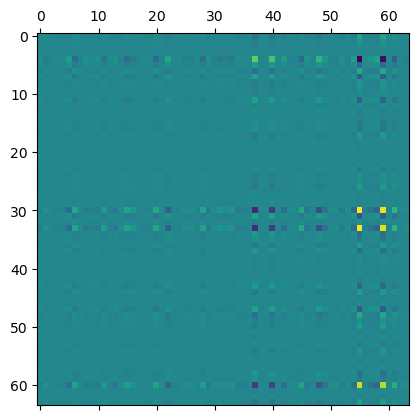

In [39]:
plt.matshow(uv_outer)

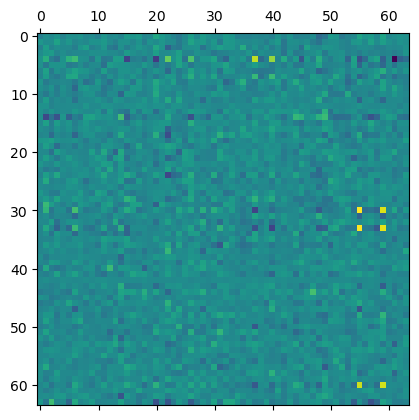

In [28]:
plt.matshow(base_model.layers[biasl[2]].weights[0][0,0].numpy())

In [7]:
#test_propagate(base_model.layers[biasl[0]])

In [8]:
def copy_layer2(layer) -> tf.keras.layers.Layer:
    config = layer.get_config()
    weights = layer.get_weights()
    layer2 = type(layer).from_config(config)
    layer2.build(layer.input_shape)
    print(weights)
    layer2.set_weights(weights + [1])
    return layer2


# layer2 = copy_layer2(model.layers[1].layers[biasl[0]])
model.layers[1].layers[biasl[0]].bias

<tf.Variable 'conv1_conv/bias:0' shape=(64,) dtype=float32, numpy=
array([ 1.5829111e-09, -1.9272978e-10,  1.4708530e-10, -3.3394246e-11,
       -1.0394472e-09, -2.2981408e-09, -5.2869503e-10, -3.1592794e-11,
        1.8323251e-10, -4.9787726e-12,  2.1595645e-09, -1.3711804e-10,
       -1.2207793e-09, -1.8223448e-09, -2.4185174e-09, -6.8378503e-10,
       -4.4311914e-09,  4.9836388e-09, -3.2121539e-09,  2.0617887e-09,
        2.9162595e-09, -3.3172360e-09,  2.6172473e-10,  1.2767545e-10,
       -4.1365911e-09,  3.1397021e-10,  9.8183450e-10,  2.9085953e-10,
       -2.2326749e-09, -3.5986544e-11,  1.9345316e-09,  2.4486041e-10,
       -3.2064138e-09, -4.0993042e-10, -2.3597533e-09,  2.2365207e-10,
        5.3403926e-09, -2.1422985e-11,  3.5645006e-10,  2.6985592e-09,
        1.2312432e-09, -6.6246014e-10,  2.1508149e-09, -5.1568672e-10,
        7.6417521e-09,  3.6630692e-11,  1.2633139e-09,  1.3274220e-09,
       -3.3828521e-10,  9.2130364e-10,  1.1556998e-09,  6.8426276e-10,
        1.

In [9]:
for l in base_model.layers:
    if isinstance(l, SparseConv2D):
        expand_layer(l)

In [42]:
followed_by_conv2d = [
    i
    for i in conv_idx
    if type(base_model.layers[i]._outbound_nodes[0].outbound_layer)
    == keras.layers.Multiply
]

In [ ]:
xgrid = 3
ygrid = 3
fig, axs = plt.subplots(xgrid,ygrid,figsize=(16,16))
for x in tqdm(range(xgrid)):
    for y in range(ygrid):
        m2 = tf.keras.Model(inputs = base_model.input, outputs = base_model.layers[biasl[x*ygrid+y]].output)
        m1 = tf.keras.Model(inputs = model.input, outputs = model.layers[0].output)
        m2 = m2(m1.output)
        ftr_model = tf.keras.Model(m1.input, m2)
        tot = 8
        base_sum = tf.zeros(ftr_model.output_shape[1:])
        for i,_ in train_ds:
            base_sum += tf.reduce_sum(ftr_model(i), axis=0)
            tot += 8
        sh = base_sum / tot
        sh -= np.min(sh)
        sh /= (np.max(sh))
        axs[x,y].matshow(sh)
        axs[x,y].axis("off")

  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
A = base_sum.numpy()
U, s, Vt = np.linalg.svd(A)

u = U[:, 0]
v = Vt[0, :]

uv_outer = np.outer(u, v)

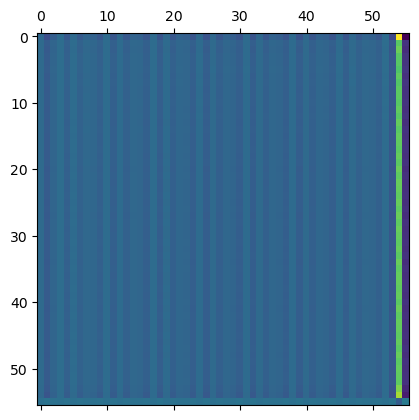

In [17]:
plt.matshow(uv_outer / tot)

In [18]:
is_bias = np.array([base_model.layers[i].use_bias for i in conv_idx])
from utils import get_weights

asort = np.argsort(get_weights(conv_idx, base_model))
is_bias[asort]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [21]:
np.array([base_model.layers[i].strides for i in conv_idx])

array([[2, 2],
       [1, 1],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1,

In [5]:
def apply_mask(out, mask, weights):
    # return out * tf.cast(tf.logical_not(mask), tf.float32) + weights * tf.cast(
    #    mask, tf.float32
    # )
    return out * tf.cast(tf.logical_not(mask), tf.float16)

In [6]:
def call_wrapper(func, mask, weights):
    def wrapper(*args, **kwargs):
        return apply_mask(func(*args, **kwargs), mask, weights)

    return wrapper

In [7]:
def set_const(layer, mask, weights):
    if not "partial" in layer.name:
        layer.default_call = layer.call
        layer._name = f"partial_{layer.name}"
    layer._mask = mask
    layer.call = call_wrapper(layer.default_call, layer._mask, weights)

In [8]:
def test():
    weights = tf.random.uniform(shape=[112, 112, 24], minval=0, maxval=4)
    mask = tf.random.uniform(shape=[112, 112, 24], minval=0, maxval=1) > 0.2
    set_const(base_model.layers[conv_idx[0]], mask, weights)
    random_input = tf.random.uniform(shape=[1, 224, 224, 3])
    out1 = base_model.layers[conv_idx[0]].call(random_input)
    out2 = base_model.layers[conv_idx[0]].default_call(random_input)
    print(tf.reduce_sum(tf.cast(out1 == out2, tf.float32) / (112 * 112 * 24)))

In [9]:
def get_activations(model):
    activations = []
    for j, (d, t) in enumerate(test_ds):
        if j == 40:
            break
        activations.append(model(d))
    return tf.concat(activations, 0)

In [ ]:
for i in tqdm(conv_idx):
    m = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[i].output)
    activations = get_activations(m)
    stds = tf.math.reduce_mean(activations**2, 0)
    means = tf.math.reduce_mean(activations, 0)
    t_min, t_cur, t_max = 0, 50, 100
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    base_accuracy = model.evaluate(test_ds, verbose=0)[1]
    min_cutoff = 0.0
    print(f"BASELINE: {base_accuracy:.5f}")
    while t_max - t_min > 100 / 2**5:
        cutoff = tfp.stats.percentile(stds, t_cur)
        set_const(base_model.layers[i], stds < cutoff, means)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
        out_accuracy = model.evaluate(test_ds, verbose=0)[1]
        if out_accuracy >= base_accuracy - 1e-3:
            t_min = t_cur
            min_cutoff = cutoff
            if out_accuracy > base_accuracy:
                base_accuracy = out_accuracy
        else:
            t_max = t_cur
        t_cur = (t_max - t_min) / 2 + t_min
        print(f"Accuracy: {out_accuracy:.5f}, threshold: {t_cur}%")
    print(f"Threshold: {min_cutoff:.5f} ({t_min}%)")
    set_const(base_model.layers[i], stds < min_cutoff, means)

  0%|          | 0/140 [00:00<?, ?it/s]

2023-02-15 12:35:04.616971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


BASELINE: 0.71240
Accuracy: 0.57120, threshold: 25.0%
Accuracy: 0.70680, threshold: 12.5%
Accuracy: 0.71000, threshold: 6.25%
Accuracy: 0.71240, threshold: 9.375%
Accuracy: 0.71160, threshold: 10.9375%
Threshold: 0.00038 (9.375%)
BASELINE: 0.71160
Accuracy: 0.58000, threshold: 25.0%
Accuracy: 0.67260, threshold: 12.5%
Accuracy: 0.71000, threshold: 6.25%
Accuracy: 0.71100, threshold: 9.375%
Accuracy: 0.70740, threshold: 7.8125%
Threshold: 0.46216 (6.25%)
BASELINE: 0.71100
Accuracy: 0.56160, threshold: 25.0%
Accuracy: 0.65840, threshold: 12.5%
Accuracy: 0.69380, threshold: 6.25%
Accuracy: 0.70300, threshold: 3.125%
Accuracy: 0.70840, threshold: 1.5625%
Threshold: 0.00000 (0%)
BASELINE: 0.71100
Accuracy: 0.65620, threshold: 25.0%
Accuracy: 0.70660, threshold: 12.5%
Accuracy: 0.71120, threshold: 18.75%
Accuracy: 0.71020, threshold: 21.875%
Accuracy: 0.70860, threshold: 20.3125%
Threshold: 7.81250 (18.75%)
BASELINE: 0.71020
Accuracy: 0.59780, threshold: 25.0%
Accuracy: 0.69520, threshold: 1

Accuracy: 0.71200, threshold: 4.6875%
Threshold: 6.71875 (3.125%)
BASELINE: 0.71200
Accuracy: 0.70700, threshold: 25.0%
Accuracy: 0.71240, threshold: 37.5%
Accuracy: 0.70980, threshold: 31.25%
Accuracy: 0.71140, threshold: 28.125%
Accuracy: 0.71240, threshold: 29.6875%
Threshold: 1.17676 (28.125%)
BASELINE: 0.71240
Accuracy: 0.70300, threshold: 25.0%
Accuracy: 0.71020, threshold: 12.5%
Accuracy: 0.71240, threshold: 18.75%
Accuracy: 0.70940, threshold: 15.625%
Accuracy: 0.71040, threshold: 14.0625%
Threshold: 0.00342 (12.5%)
BASELINE: 0.71240
Accuracy: 0.71160, threshold: 75.0%
Accuracy: 0.71020, threshold: 62.5%
Accuracy: 0.71220, threshold: 68.75%
Accuracy: 0.71000, threshold: 65.625%
Accuracy: 0.71220, threshold: 67.1875%
Threshold: 0.06604 (65.625%)
BASELINE: 0.71220
Accuracy: 0.70700, threshold: 25.0%
Accuracy: 0.71020, threshold: 12.5%
Accuracy: 0.71040, threshold: 6.25%
Accuracy: 0.71180, threshold: 9.375%
Accuracy: 0.71200, threshold: 10.9375%
Threshold: 10.35156 (9.375%)
BASELI

In [ ]:
for i in tqdm(conv_idx):
    m = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[i].output)
    activations = get_activations(m)
    stds = tf.math.reduce_std(activations, 0)
    means = tf.math.reduce_mean(activations, 0)
    t_min, t_cur, t_max = 0, 50, 100
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    base_accuracy = model.evaluate(test_ds, verbose=0)[1]
    min_cutoff = 0.0
    print(f"BASELINE: {base_accuracy:.5f}")
    while t_max - t_min > 100 / 2**5:
        cutoff = tfp.stats.percentile(stds, t_cur)
        set_const(base_model.layers[i], stds < cutoff, means)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
        out_accuracy = model.evaluate(test_ds, verbose=0)[1]
        if out_accuracy >= base_accuracy - 1e-3:
            t_min = t_cur
            min_cutoff = cutoff
            if out_accuracy > base_accuracy:
                base_accuracy = out_accuracy
        else:
            t_max = t_cur
        t_cur = (t_max - t_min) / 2 + t_min
        print(f"Accuracy: {out_accuracy:.5f}, threshold: {t_cur}%")
    print(f"Threshold: {min_cutoff:.5f} ({t_min}%)")
    set_const(base_model.layers[i], stds < min_cutoff, means)